In [1]:
import ssl

# WARNING: this disables SSL certificate verification globally in this process
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=False,   # first time: actually download
    transform=transform_mnist
)

batch_size = 64
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

len(mnist_dataset)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 369kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.46MB/s]


60000

In [3]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)


Torch: 2.9.1
Torchvision: 0.24.1


In [3]:
# %% [markdown]
# # GANs in the Real World: When Do They Fail?
#
# This notebook extends a simple MNIST GAN example to show **when GANs work well**
# and **when they do not**.
#
# We will:
#
# 1. Review a tiny GAN that works reasonably well on MNIST digits.
# 2. Re-use the same architecture on harder datasets:
#    - Fashion-MNIST (clothing)
#    - CIFAR-10 (natural color images)
#    - A **tiny, imbalanced** MNIST subset
# 3. Visually compare the results and discuss **limitations of GANs**:
#    - Data complexity (color, background, structure)
#    - Data quantity and balance
#    - Mode collapse and memorization
#
# This notebook is aimed at undergraduates who know basic Python but may be seeing GANs for the first time.

# %% [markdown]
# ## 0. Setup: Imports and Device

# %%
# If running on a fresh environment, you may need to install PyTorch and torchvision.
# You can uncomment and run the line below if PyTorch is not installed.
# !pip3 install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

This is the first portion

In [4]:
# %% [markdown]
# ## 1. Quick Review: What is a GAN?
#
# A **Generative Adversarial Network (GAN)** has two neural networks playing a game:
#
# - **Generator (G)**: takes random noise as input and tries to create fake images that **look real**.
# - **Discriminator (D)**: takes an image as input and tries to decide whether it is **real** (from the dataset) or **fake** (from the generator).
#
# You can think of it like:
#
# - The generator is a *forger* trying to create fake art.
# - The discriminator is a *detective* trying to spot fake art.
#
# Over time, both get better:
#
# - The generator makes more realistic images.
# - The discriminator becomes a better critic.
#
# We will use a very small GAN, based on fully connected (MLP) networks.

# %% [markdown]
# ## 2. A Tiny MLP GAN: Reusable Building Blocks

# %%
# We'll define a **generic** MLP Generator and Discriminator
# that can work with any flattened image size (e.g., 28x28 or 32x32x3).


class GeneratorMLP(nn.Module):
    """
    Simple MLP Generator.
    Input: noise vector z of size z_dim.
    Output: flattened image of size img_size, then reshaped to (C, H, W).
    """
    def __init__(self, z_dim, img_size, img_channels=1):
        super().__init__()
        self.z_dim = z_dim
        self.img_size = img_size  # total pixels = C*H*W
        self.img_channels = img_channels

        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, img_size),
            nn.Tanh()  # output in [-1, 1]
        )

    def forward(self, z):
        x = self.model(z)
        # reshape to (batch_size, C, H, W)
        # We assume square images for simplicity.
        side = int((self.img_size // self.img_channels) ** 0.5)
        return x.view(-1, self.img_channels, side, side)


class DiscriminatorMLP(nn.Module):
    """
    Simple MLP Discriminator.
    Input: image tensor of shape (B, C, H, W).
    Output: probability in [0,1] that the image is real.
    """
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # flatten image to vector (B, img_size)
        x = x.view(x.size(0), -1)
        return self.model(x)


# We'll also define a helper function to train this GAN on any dataset.


def train_gan(
    dataloader,
    img_channels=1,
    z_dim=64,
    num_epochs=5,
    lr=2e-4,
    print_every=200,
    title_prefix="GAN"
):
    """
    Train a tiny MLP GAN (Generator + Discriminator) on a given dataloader.

    Returns:
        generator (trained model),
        G_losses, D_losses (lists),
        fixed_noise (for visualization),
        example_real_batch (a small batch of real images)
    """
    # Determine image size from one batch
    real_batch = next(iter(dataloader))[0]
    _, C, H, W = real_batch.shape
    img_size = C * H * W

    generator = GeneratorMLP(z_dim, img_size, img_channels=C).to(device)
    discriminator = DiscriminatorMLP(img_size).to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    # Fixed noise for monitoring progress
    fixed_noise = torch.randn(32, z_dim, device=device)

    G_losses = []
    D_losses = []

    step = 0
    for epoch in range(num_epochs):
        for batch_idx, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size_curr = real_imgs.size(0)

            # ============================
            # 1. Train Discriminator
            # ============================
            discriminator.zero_grad()

            # Real images: label = 1
            labels_real = torch.ones(batch_size_curr, 1, device=device)
            output_real = discriminator(real_imgs)
            loss_D_real = criterion(output_real, labels_real)

            # Fake images: label = 0
            noise = torch.randn(batch_size_curr, z_dim, device=device)
            fake_imgs = generator(noise)
            labels_fake = torch.zeros(batch_size_curr, 1, device=device)
            output_fake = discriminator(fake_imgs.detach())
            loss_D_fake = criterion(output_fake, labels_fake)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optimizer_D.step()

            # ============================
            # 2. Train Generator
            # ============================
            generator.zero_grad()

            noise = torch.randn(batch_size_curr, z_dim, device=device)
            fake_imgs = generator(noise)
            labels_for_G = torch.ones(batch_size_curr, 1, device=device)
            output = discriminator(fake_imgs)
            loss_G = criterion(output, labels_for_G)

            loss_G.backward()
            optimizer_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            if batch_idx % print_every == 0:
                print(
                    f"{title_prefix} | "
                    f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Batch [{batch_idx}/{len(dataloader)}] "
                    f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}"
                )

            step += 1

    print(f"{title_prefix}: Training complete.")
    return generator, G_losses, D_losses, fixed_noise, real_batch


def plot_losses(G_losses, D_losses, title="GAN Training Losses"):
    plt.figure(figsize=(6, 4))
    plt.plot(G_losses, label="Generator loss")
    plt.plot(D_losses, label="Discriminator loss")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


def show_images(images, nrow=8, title="Images"):
    """
    Display a grid of images (tensor shape: (N, C, H, W)).
    Assumes images have values in [-1, 1] or [0, 1].
    """
    images = images.detach().cpu()

    # If images are in [-1,1], convert to [0,1] for display
    if images.min() < 0:
        images = (images + 1) / 2

    N = min(images.size(0), nrow ** 2)
    C = images.size(1)

    rows = nrow
    cols = nrow
    plt.figure(figsize=(cols, rows))
    for i in range(N):
        plt.subplot(rows, cols, i + 1)
        img = images[i]
        if C == 1:
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            # reshape (C,H,W) to (H,W,C)
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


In [5]:
# %% [markdown]
# ## 1. Tiny MLP GAN (Reusable)
#
# We define a small **Generator** and **Discriminator** that take flattened images
# (e.g., 28×28) and work for both MNIST and Fashion-MNIST.

# %%
class GeneratorMLP(nn.Module):
    def __init__(self, z_dim, img_size, img_channels=1):
        super().__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.img_channels = img_channels

        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, img_size),
            nn.Tanh()  # [-1, 1]
        )

    def forward(self, z):
        x = self.model(z)
        side = int((self.img_size // self.img_channels) ** 0.5)
        return x.view(-1, self.img_channels, side, side)


class DiscriminatorMLP(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


def train_gan(
    dataloader,
    img_channels=1,
    z_dim=64,
    num_epochs=3,
    lr=2e-4,
    print_every=200,
    title_prefix="GAN"
):
    """
    Train the tiny MLP GAN on a given dataloader.

    Returns:
        generator, G_losses, D_losses, fixed_noise
    """
    # Get image shape from one batch
    real_batch = next(iter(dataloader))[0]
    _, C, H, W = real_batch.shape
    img_size = C * H * W

    generator = GeneratorMLP(z_dim, img_size, img_channels=C).to(device)
    discriminator = DiscriminatorMLP(img_size).to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    fixed_noise = torch.randn(32, z_dim, device=device)

    G_losses, D_losses = [], []
    step = 0

    for epoch in range(num_epochs):
        for batch_idx, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size_curr = real_imgs.size(0)

            # ---- Train Discriminator ----
            discriminator.zero_grad()

            labels_real = torch.ones(batch_size_curr, 1, device=device)
            output_real = discriminator(real_imgs)
            loss_D_real = criterion(output_real, labels_real)

            noise = torch.randn(batch_size_curr, z_dim, device=device)
            fake_imgs = generator(noise)
            labels_fake = torch.zeros(batch_size_curr, 1, device=device)
            output_fake = discriminator(fake_imgs.detach())
            loss_D_fake = criterion(output_fake, labels_fake)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optimizer_D.step()

            # ---- Train Generator ----
            generator.zero_grad()
            noise = torch.randn(batch_size_curr, z_dim, device=device)
            fake_imgs = generator(noise)
            labels_for_G = torch.ones(batch_size_curr, 1, device=device)
            output = discriminator(fake_imgs)
            loss_G = criterion(output, labels_for_G)
            loss_G.backward()
            optimizer_G.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            if batch_idx % print_every == 0:
                print(
                    f"{title_prefix} | "
                    f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Batch [{batch_idx}/{len(dataloader)}] "
                    f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}"
                )
            step += 1

    print(f"{title_prefix}: Training complete.")
    return generator, G_losses, D_losses, fixed_noise


def show_images(images, nrow=4, title="Images"):
    """
    Display a grid of images (tensor of shape (N, C, H, W)).
    Handles [-1,1] or [0,1] ranges.
    """
    images = images.detach().cpu()

    # If images are in [-1,1], convert to [0,1]
    if images.min() < 0:
        images = (images + 1) / 2

    N = min(images.size(0), nrow ** 2)
    C = images.size(1)

    plt.figure(figsize=(nrow, nrow))
    for i in range(N):
        plt.subplot(nrow, nrow, i + 1)
        img = images[i]
        if C == 1:
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


In [16]:
import ssl

# WARNING: this disables SSL certificate verification for HTTPS
ssl._create_default_https_context = ssl._create_unverified_context


In [6]:
# %% [markdown]
# ## 2. MNIST (Digits) – Baseline
#
# First, we (re)train this tiny GAN on MNIST digits to see where it **works**.

# %%
from torchvision import datasets, transforms

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root="data", train=True, download=False, transform=transform_mnist)
batch_size = 64
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
len(mnist_dataset)



60000

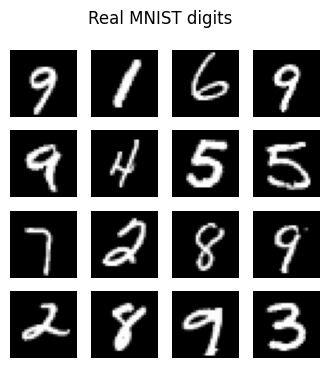

In [7]:
# View a few real MNIST digits
real_batch = next(iter(mnist_loader))
images, labels = real_batch

show_images(images[:16], nrow=4, title="Real MNIST digits")


In [8]:
z_dim = 64  # size of noise vector

gen_mnist, G_losses_mnist, D_losses_mnist, fixed_noise_mnist = train_gan(
    mnist_loader,
    img_channels=1,
    z_dim=z_dim,
    num_epochs=3,   # you can bump this to 5 if you want better digits
    lr=2e-4,
    print_every=300,
    title_prefix="MNIST GAN"
)


MNIST GAN | Epoch [1/3] Batch [0/938] Loss D: 1.4172, Loss G: 0.7251
MNIST GAN | Epoch [1/3] Batch [300/938] Loss D: 0.2826, Loss G: 2.6208
MNIST GAN | Epoch [1/3] Batch [600/938] Loss D: 0.0527, Loss G: 5.7321
MNIST GAN | Epoch [1/3] Batch [900/938] Loss D: 0.2720, Loss G: 3.9248
MNIST GAN | Epoch [2/3] Batch [0/938] Loss D: 0.2175, Loss G: 4.7029
MNIST GAN | Epoch [2/3] Batch [300/938] Loss D: 0.2231, Loss G: 2.5108
MNIST GAN | Epoch [2/3] Batch [600/938] Loss D: 0.4948, Loss G: 3.5928
MNIST GAN | Epoch [2/3] Batch [900/938] Loss D: 0.2325, Loss G: 3.0561
MNIST GAN | Epoch [3/3] Batch [0/938] Loss D: 0.7425, Loss G: 1.8401
MNIST GAN | Epoch [3/3] Batch [300/938] Loss D: 0.4747, Loss G: 3.1007
MNIST GAN | Epoch [3/3] Batch [600/938] Loss D: 1.2459, Loss G: 1.7713
MNIST GAN | Epoch [3/3] Batch [900/938] Loss D: 0.8202, Loss G: 1.7580
MNIST GAN: Training complete.


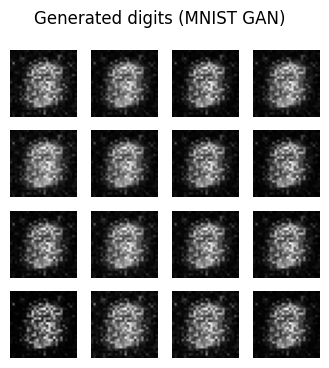

GeneratorMLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [9]:
gen_mnist.eval()
with torch.no_grad():
    fake_samples_mnist = gen_mnist(fixed_noise_mnist.to(device))

show_images(fake_samples_mnist[:16], nrow=4, title="Generated digits (MNIST GAN)")
gen_mnist.train()


In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_fashion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,          # first time: True; later you can use False
    transform=transform_fashion
)

fashion_loader = DataLoader(fashion_dataset, batch_size=64, shuffle=True)
len(fashion_dataset)


100%|██████████| 26.4M/26.4M [00:52<00:00, 507kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 153kB/s]
100%|██████████| 4.42M/4.42M [00:09<00:00, 486kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.11MB/s]


60000

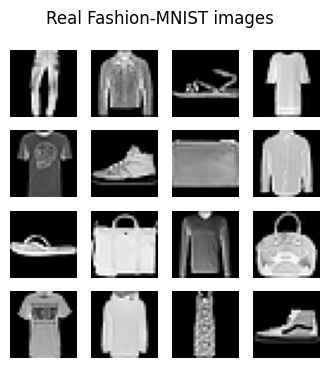

In [12]:
real_batch_fashion = next(iter(fashion_loader))
images_fashion, labels_fashion = real_batch_fashion

show_images(images_fashion[:16], nrow=4, title="Real Fashion-MNIST images")


In [13]:
gen_fashion, G_losses_fashion, D_losses_fashion, fixed_noise_fashion = train_gan(
    fashion_loader,
    img_channels=1,
    z_dim=z_dim,
    num_epochs=3,       # adjust up/down depending on time
    lr=2e-4,
    print_every=300,
    title_prefix="Fashion-MNIST GAN"
)


Fashion-MNIST GAN | Epoch [1/3] Batch [0/938] Loss D: 1.3483, Loss G: 0.7340
Fashion-MNIST GAN | Epoch [1/3] Batch [300/938] Loss D: 0.2454, Loss G: 2.7639
Fashion-MNIST GAN | Epoch [1/3] Batch [600/938] Loss D: 0.0499, Loss G: 4.5656
Fashion-MNIST GAN | Epoch [1/3] Batch [900/938] Loss D: 0.0835, Loss G: 4.8084
Fashion-MNIST GAN | Epoch [2/3] Batch [0/938] Loss D: 0.0531, Loss G: 4.6734
Fashion-MNIST GAN | Epoch [2/3] Batch [300/938] Loss D: 0.0659, Loss G: 4.5522
Fashion-MNIST GAN | Epoch [2/3] Batch [600/938] Loss D: 0.0212, Loss G: 5.5212
Fashion-MNIST GAN | Epoch [2/3] Batch [900/938] Loss D: 0.1332, Loss G: 5.8295
Fashion-MNIST GAN | Epoch [3/3] Batch [0/938] Loss D: 0.1059, Loss G: 5.6660
Fashion-MNIST GAN | Epoch [3/3] Batch [300/938] Loss D: 0.0351, Loss G: 6.3862
Fashion-MNIST GAN | Epoch [3/3] Batch [600/938] Loss D: 0.0291, Loss G: 4.8554
Fashion-MNIST GAN | Epoch [3/3] Batch [900/938] Loss D: 0.1097, Loss G: 8.0040
Fashion-MNIST GAN: Training complete.


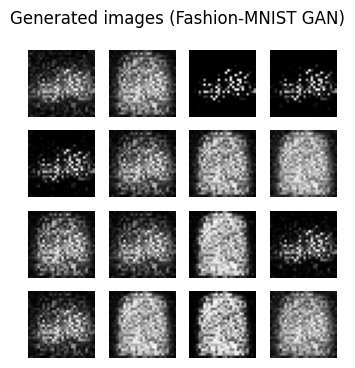

GeneratorMLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [14]:
gen_fashion.eval()
with torch.no_grad():
    fake_samples_fashion = gen_fashion(fixed_noise_fashion.to(device))

show_images(fake_samples_fashion[:16], nrow=4, title="Generated images (Fashion-MNIST GAN)")
gen_fashion.train()


In [15]:
import torch

targets = mnist_dataset.targets  # labels for full MNIST train set

mask_1 = (targets == 1)
mask_7 = (targets == 7)

indices_1 = torch.where(mask_1)[0][:450]  # 450 ones
indices_7 = torch.where(mask_7)[0][:50]   # 50 sevens

small_indices = torch.cat([indices_1, indices_7])
small_mnist_dataset = Subset(mnist_dataset, small_indices)

small_loader = DataLoader(small_mnist_dataset, batch_size=64, shuffle=True)
len(small_mnist_dataset)


500

Labels in this batch: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7]


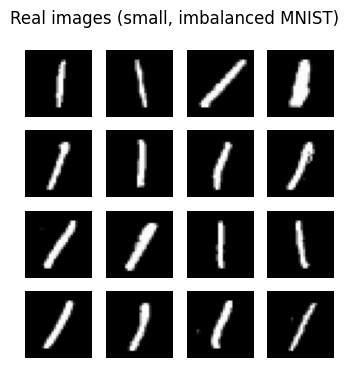

In [16]:
real_batch_small = next(iter(small_loader))
images_small, labels_small = real_batch_small

print("Labels in this batch:", labels_small.tolist())
show_images(images_small[:16], nrow=4, title="Real images (small, imbalanced MNIST)")


In [17]:
gen_small, G_losses_small, D_losses_small, fixed_noise_small = train_gan(
    small_loader,
    img_channels=1,
    z_dim=z_dim,
    num_epochs=6,      # small dataset → a few more epochs
    lr=2e-4,
    print_every=30,
    title_prefix="Small Imbalanced MNIST GAN"
)


Small Imbalanced MNIST GAN | Epoch [1/6] Batch [0/8] Loss D: 1.3951, Loss G: 0.7244
Small Imbalanced MNIST GAN | Epoch [2/6] Batch [0/8] Loss D: 0.8540, Loss G: 0.6896
Small Imbalanced MNIST GAN | Epoch [3/6] Batch [0/8] Loss D: 0.8148, Loss G: 0.6061
Small Imbalanced MNIST GAN | Epoch [4/6] Batch [0/8] Loss D: 0.9347, Loss G: 0.5314
Small Imbalanced MNIST GAN | Epoch [5/6] Batch [0/8] Loss D: 0.8868, Loss G: 0.6009
Small Imbalanced MNIST GAN | Epoch [6/6] Batch [0/8] Loss D: 0.7847, Loss G: 0.8761
Small Imbalanced MNIST GAN: Training complete.


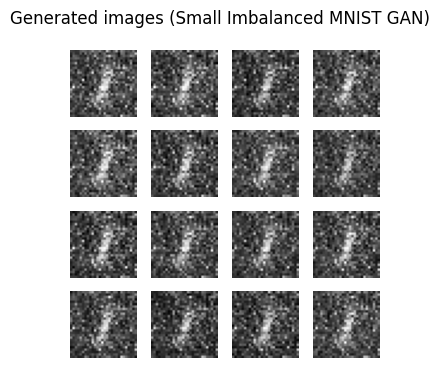

GeneratorMLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [18]:
gen_small.eval()
with torch.no_grad():
    fake_samples_small = gen_small(fixed_noise_small.to(device))

show_images(fake_samples_small[:16], nrow=4, title="Generated images (Small Imbalanced MNIST GAN)")
gen_small.train()
